## End member mixing analysis (EMMA) to determine streamflow source contributions

### Principal components analysis using conservative tracers using the python scikit-learn library.​

#### Here we started with solute data from Hungerford Brook late winter/early spring flow events captured with ISCOs. Data include:
- ICP-OES (Al, Ca, Cu, Fe, K, Mg, Mn, Na,P,Zn,Si
- IC and total elemental analyser data (Cl, SO4, NO3, PO4, TOC, DIN)
- Stable isotopes (dD, d18O)

Data are from the BREE OneDrive directory (Watershed Data>1_Projects>EMMA>Working file for MATLAB 2023)

- For HB 2022 timeseries, 17 parameters total
- 5 were found to be relatively conservative: Cl, Ca, Na, Si, and Mg
- See "bivariates" notebook for those plots

The linear regression model is fitted for each conservative tracer using the first two principal components as the independent variables. The contributions are then normalized to sum to 1 for each sample. The resulting dataframe streamflow_with_contributions contains the original streamflow data along with the contributions of each endmember.

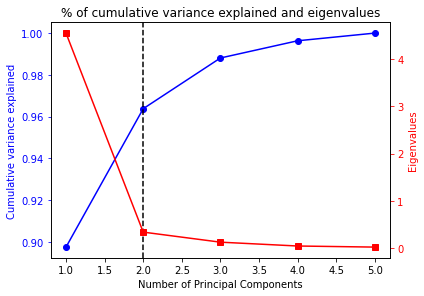

In [20]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the data from the CSV file
data = pd.read_csv("/home/millieginty/Documents/git-repos/EMMA/data/Data_for_EMMA_2022_HB.csv")

# Select the specific parameters of interest
selected_parameters = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L']

# Extract the subset of data for selected parameters
subset_data = data[selected_parameters]

# Standardize the data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(subset_data)

# Apply PCA
pca = PCA()  # Don't specify the number of components for now
pca_result = pca.fit_transform(scaled_data)

# Plot the percentage of cumulative variance explained on the primary y-axis
fig, ax1 = plt.subplots()

ax1.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum(), 
         marker='o', color='blue', label='Cumulative Variance Explained')
ax1.set_xlabel('Number of Principal Components')
ax1.set_ylabel('Cumulative variance explained', color='blue')
ax1.tick_params('y', colors='blue')

# Plot a horizonal line at explain variance >80%, satifying the Christopherson & Hooper (1992) rule
ax1.axvline(x=2, color='black', linestyle='--')

# Create a second y-axis for eigenvalues
ax2 = ax1.twinx()
ax2.plot(range(1, len(pca.explained_variance_) + 1), 
         pca.explained_variance_, 
         marker='s', color='red', linestyle='-', label='Eigenvalues')
ax2.set_ylabel('Eigenvalues', color='red')
ax2.tick_params('y', colors='red')

# Plot a horizonal line at eigenvalues > 1, satifying the 'retain all ev >1 rule' (Hooper, 2003)
#ax2.axhline(y=1, color='black', linestyle='-')

# Display the legend
fig.tight_layout()
#fig.legend(loc='upper left', bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.title('% of cumulative variance explained and eigenvalues')
plt.show()

### Once we have a specific number of components in mind, we can modify the n_components parameter when creating the PCA object:

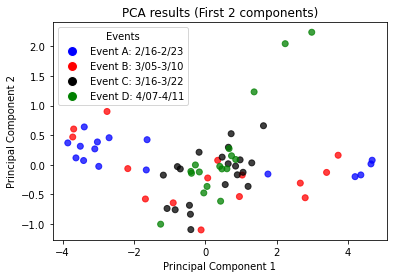

In [21]:
# Load the data from the CSV file
data = pd.read_csv("/home/millieginty/Documents/git-repos/EMMA/data/Data_for_EMMA_2022_HB.csv")

# Convert the 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%y')

# Select the specific parameters of interest
selected_parameters = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L']

# Extract the subset of data for selected parameters
subset_data = data[selected_parameters]

# Standardize the data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(subset_data)

# Apply PCA
pca = PCA(n_components=2)  # Specify the number of components
pca_result = pca.fit_transform(scaled_data)

# Add a column for the event based on the date
data['Event'] = 'Unknown'
data.loc[(data['Date'] >= '2022-02-16') & (data['Date'] <= '2022-02-23'), 'Event'] = 'Event A: 2/16-2/23'
data.loc[(data['Date'] >= '2022-03-05') & (data['Date'] <= '2022-03-10'), 'Event'] = 'Event B: 3/05-3/10'
data.loc[(data['Date'] >= '2022-03-16') & (data['Date'] <= '2022-03-22'), 'Event'] = 'Event C: 3/16-3/22'
data.loc[(data['Date'] >= '2022-04-07') & (data['Date'] <= '2022-04-11'), 'Event'] = 'Event D: 4/07-4/11'

# Define colors for each event
event_colors = {'Event A: 2/16-2/23': 'blue', 'Event B: 3/05-3/10': 'red', \
                'Event C: 3/16-3/22': 'black', 'Event D: 4/07-4/11': 'green'}

# Plot the PCA results with color-coded events
colors = data['Event'].map(event_colors)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=colors, alpha=0.75)
plt.title('PCA results (First 2 components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=event,
                      markerfacecolor=color, markersize=10)
           for event, color in event_colors.items()]
plt.legend(handles=handles, title='Events')

plt.show()

## Now we'll add the (scaled) candidate endmembers to the PC1 vs PC2 space plot:

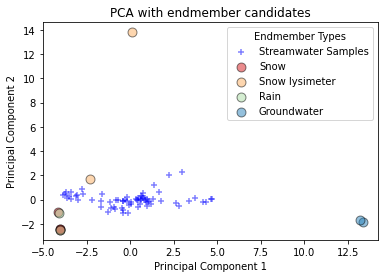

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load streamwater data from the CSV file
streamwater_data = pd.read_csv("/home/millieginty/Documents/git-repos/EMMA/data/Data_for_EMMA_2022_HB.csv")

# Convert the 'Date' column to datetime
#streamwater_data['Date'] = pd.to_datetime(streamwater_data['Date'], format='%m/%d/%y')

# Select the specific parameters of interest
selected_parameters = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L']

# Extract the subset of data for selected parameters
subset_streamwater = streamwater_data[selected_parameters]

# Standardize the streamwater data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_streamwater = scaler.fit_transform(subset_streamwater)

# Apply PCA to streamwater data
pca_streamwater = PCA(n_components=2)
pca_result_streamwater = pca_streamwater.fit_transform(scaled_streamwater)

# Save the PCA results for an EMMA later
pcs = ["Principal Component 1", "Principal Component 2"]
pca_2Dresult_streamwater = pd.DataFrame(pca_result_streamwater, columns=pcs)
pca_2Dresult_streamwater.to_csv("/home/millieginty/Documents/git-repos/EMMA/analysis/pca_result_streamwater.csv",\
                                index=False, header=True)


# Add a column for the event based on the date
#streamwater_data['Event'] = 'Unknown'
#streamwater_data.loc[(streamwater_data['Date'] >= '2022-02-16') & (streamwater_data['Date'] <= '2022-02-23'), 'Event'] = 'Event A'
#streamwater_data.loc[(streamwater_data['Date'] >= '2022-03-05') & (streamwater_data['Date'] <= '2022-03-10'), 'Event'] = 'Event B'
#streamwater_data.loc[(streamwater_data['Date'] >= '2022-03-16') & (streamwater_data['Date'] <= '2022-03-22'), 'Event'] = 'Event C'
#streamwater_data.loc[(streamwater_data['Date'] >= '2022-04-07') & (streamwater_data['Date'] <= '2022-04-11'), 'Event'] = 'Event D'

# Define colors for each event
#event_colors = {'Event A': 'blue', 'Event B': 'blue', 'Event C': 'blue', 'Event D': 'blue'}

# Plot streamwater PCA results with blue '+' markers
plt.scatter(pca_result_streamwater[:, 0], pca_result_streamwater[:, 1], marker='+', c='blue', alpha=0.5, label='Streamwater Samples')

# Add a legend for streamwater samples
handles_streamwater = [plt.Line2D([0], [0], marker='+', color='w', label='Streamwater Samples',
                                  markerfacecolor='blue', markersize=10)]
plt.legend(handles=handles_streamwater)

# Load potential endmembers from the separate CSV file
endmember_data = pd.read_csv("/home/millieginty/Documents/git-repos/EMMA/data/end_members_2022_HB.csv")

# Convert the 'Date' column to datetime in the endmember data
endmember_data['Date'] = pd.to_datetime(endmember_data['Date'], format='%m/%d/%y')

# Extract the subset of data for selected parameters in endmembers
subset_endmembers = endmember_data[selected_parameters]

# Handle missing values in endmembers (replace with mean)
subset_endmembers = subset_endmembers.fillna(subset_endmembers.mean())

# Standardize the endmember data (mean=0 and variance=1)
scaled_endmembers = scaler.transform(subset_endmembers)

# Apply PCA to endmember data
pca_endmembers = PCA(n_components=2)
pca_result_endmembers = pca_endmembers.fit_transform(scaled_endmembers)

# Plot all potential endmembers with colored circle markers
for event_type, color in zip(endmember_data['Type'].unique(), ['#d7191c', '#fdae61', '#abdda4', '#2b83ba']):
    indices = endmember_data['Type'] == event_type
    plt.scatter(pca_result_endmembers[indices, 0], pca_result_endmembers[indices, 1], marker='o', c=color, \
                alpha=0.50, label=event_type, edgecolors= "black", s = 80)

# Add a legend for endmember types
plt.legend(title='Endmember Types')

plt.title('PCA with endmember candidates')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()